# Comparaison des modèles — Vue d'ensemble

Ce notebook génère des graphiques comparatifs entre **tous les modèles** entraînés :
- RNN, LSTM, GRU (réseaux récurrents)
- XGBoost (baseline gradient boosting)
- VanillaTransformer, PatchTST, TimeXer, iTransformer (attention)

## ⚠️ Prérequis
Exécuter d'abord **chaque notebook de modèle** dans cet ordre :
1. `rnn.ipynb`
2. `lstm.ipynb`
3. `gru.ipynb`
4. `xgboost.ipynb`
5. `transformers.ipynb`

Chaque notebook sauvegarde ses résultats dans `results/`, que ce notebook charge ensuite.

## Graphiques produits
| # | Graphique | Description |
|---|---|---|
| 1 | **Barplots métriques** | MAE / MAPE / RMSE / R² — val (opaque) et test (transparent) |
| 2 | **Prédictions vs Réel** | Toutes les courbes superposées sur la semaine de test |
| 3 | **Heatmap récapitulatif** | Tableau coloré (vert = bon, rouge = mauvais) |
| 4 | **Radar chart** | Vue synthétique des performances relatives sur les 4 métriques |

In [1]:
import json
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd

IMG_PATH     = '../img/compare_models.png'
RESULTS_DIR  = '../results'

# Ordre d'affichage des modèles (par famille)
MODEL_ORDER = ['RNN', 'LSTM', 'GRU', 'XGBoost',
               'VanillaTransformer', 'PatchTST', 'TimeXer', 'iTransformer']

In [2]:
# ── Chargement de tous les résultats JSON ─────────────────────────────────
all_results = []

json_files = sorted(glob.glob(os.path.join(RESULTS_DIR, '*.json')))
if not json_files:
    raise FileNotFoundError(
        f'Aucun fichier JSON trouvé dans {RESULTS_DIR}/\n'
        'Exécutez d\'abord chaque notebook de modèle.'
    )

for path in json_files:
    with open(path) as f:
        data = json.load(f)
    # transformers_results.json contient une liste
    if isinstance(data, list):
        all_results.extend(data)
    else:
        all_results.append(data)

# Trier selon MODEL_ORDER
order_map   = {m: i for i, m in enumerate(MODEL_ORDER)}
all_results = sorted(all_results, key=lambda r: order_map.get(r['model'], 99))

names      = [r['model'] for r in all_results]
colors     = [r['color'] for r in all_results]
real_real  = np.array(all_results[0]['real'])         # identique pour tous
day_labels = all_results[0]['day_labels']
test_label = all_results[0]['test_label']

print(f'{len(all_results)} modèles chargés : {names}')
print(f'Semaine de test : {test_label}')

8 modèles chargés : ['RNN', 'LSTM', 'GRU', 'XGBoost', 'VanillaTransformer', 'PatchTST', 'TimeXer', 'iTransformer']
Semaine de test : S39/2023


## 1 — Barplots des métriques

Pour chaque métrique, les barres **opaques** = Val (1-step direct), **transparentes** = Test (autorégressif 5 jours).

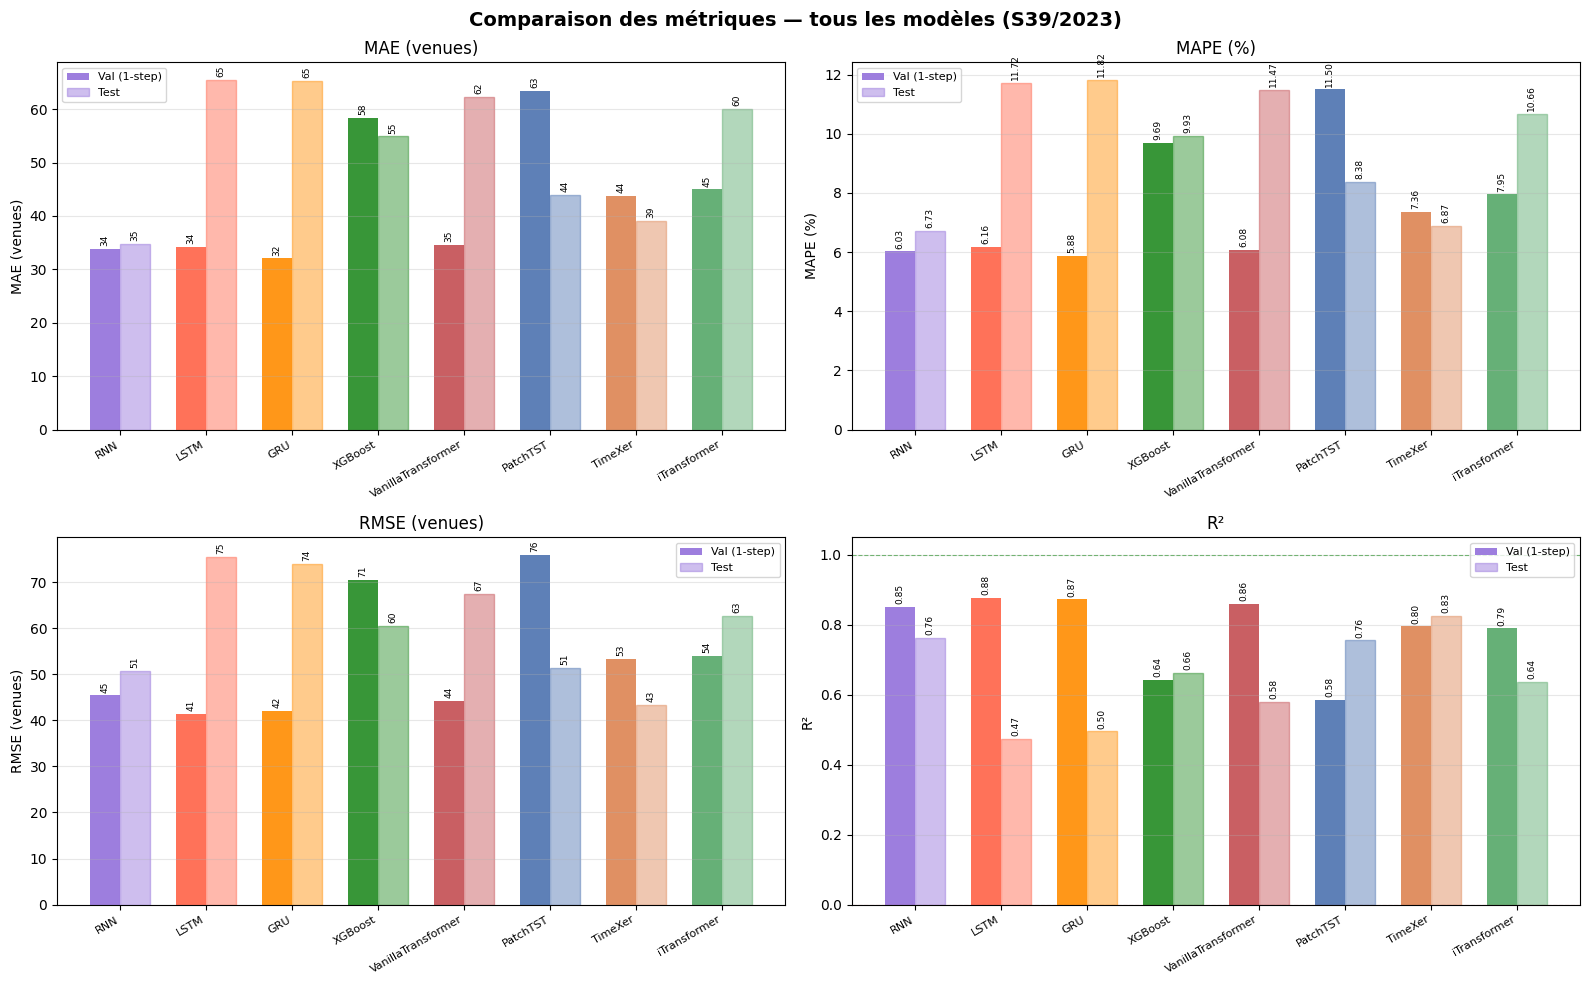

Sauvegardé → img/compare_models_metrics.png


In [3]:
metrics_info = [
    ('MAE',  'MAE (venues)',     False),
    ('MAPE', 'MAPE (%)',         False),
    ('RMSE', 'RMSE (venues)',    False),
    ('R2',   'R²',               True ),   # True = higher is better
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Comparaison des métriques — tous les modèles ({test_label})',
             fontsize=14, fontweight='bold')

x     = np.arange(len(names))
width = 0.35

for ax, (key, ylabel, higher_better) in zip(axes.flat, metrics_info):
    vals_val  = [r['val'][key]  for r in all_results]
    vals_test = [r['test'][key] for r in all_results]

    b1 = ax.bar(x - width/2, vals_val,  width, color=colors, alpha=0.90, label='Val (1-step)')
    b2 = ax.bar(x + width/2, vals_test, width, color=colors, alpha=0.45, label='Test',
                edgecolor=colors, linewidth=1)

    fmt = '.2f' if key in ('MAPE', 'R2') else '.0f'
    ax.bar_label(b1, fmt=f'%{fmt}', fontsize=6.5, padding=2, rotation=90)
    ax.bar_label(b2, fmt=f'%{fmt}', fontsize=6.5, padding=2, rotation=90)

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=30, ha='right', fontsize=8)
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

    # Ligne de référence pour R²
    if key == 'R2':
        ax.axhline(0, color='red', ls='--', lw=0.8, alpha=0.5, label='R²=0 (modèle naïf)')
        ax.axhline(1, color='green', ls='--', lw=0.8, alpha=0.5)

plt.tight_layout()
plt.savefig(IMG_PATH.replace('.png', '_metrics.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Sauvegardé → img/compare_models_metrics.png')

## 2 — Prédictions vs Réel

Toutes les courbes de prédiction superposées sur la semaine de test.

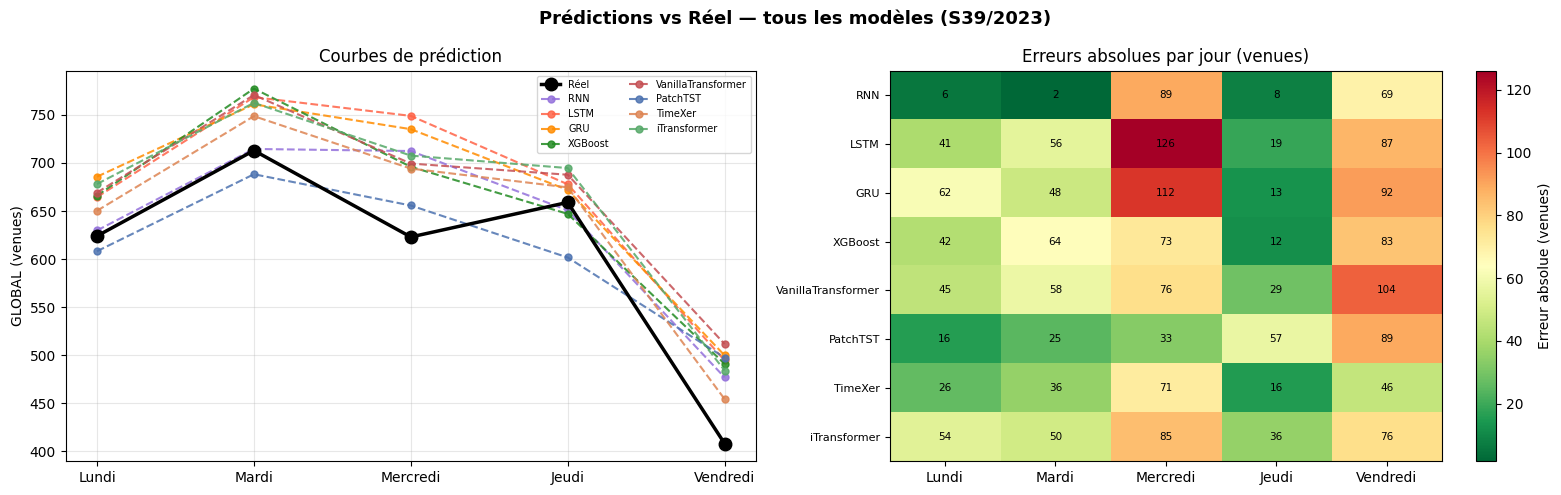

Sauvegardé → img/compare_models_preds.png


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(f'Prédictions vs Réel — tous les modèles ({test_label})',
             fontsize=13, fontweight='bold')

# ── Gauche : courbes ─────────────────────────────────────────────────────
ax = axes[0]
ax.plot(day_labels, real_real, 'ko-', lw=2.5, ms=9, zorder=10, label='Réel')
for r in all_results:
    ax.plot(day_labels, r['preds'], 'o--', lw=1.5, ms=5,
            color=r['color'], label=r['model'], alpha=0.85)
ax.set_ylabel('GLOBAL (venues)')
ax.set_title('Courbes de prédiction')
ax.legend(fontsize=7, ncol=2)
ax.grid(alpha=0.3)

# ── Droite : erreurs absolues par modèle et par jour ─────────────────────
ax = axes[1]
errors = np.array([np.abs(np.array(r['preds']) - real_real) for r in all_results])
im = ax.imshow(errors, aspect='auto', cmap='RdYlGn_r')
ax.set_xticks(range(len(day_labels)))
ax.set_xticklabels(day_labels)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=8)
ax.set_title('Erreurs absolues par jour (venues)')
for i in range(len(all_results)):
    for j in range(len(day_labels)):
        ax.text(j, i, f'{errors[i, j]:.0f}', ha='center', va='center',
                fontsize=7.5, color='black')
plt.colorbar(im, ax=ax, label='Erreur absolue (venues)')

plt.tight_layout()
plt.savefig(IMG_PATH.replace('.png', '_preds.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Sauvegardé → img/compare_models_preds.png')

## 3 — Tableau récapitulatif (heatmap)

- **Vert** = bonne valeur (faible erreur ou R² élevé)
- **Rouge** = mauvaise valeur
- Chaque colonne est normalisée indépendamment pour faciliter la lecture.

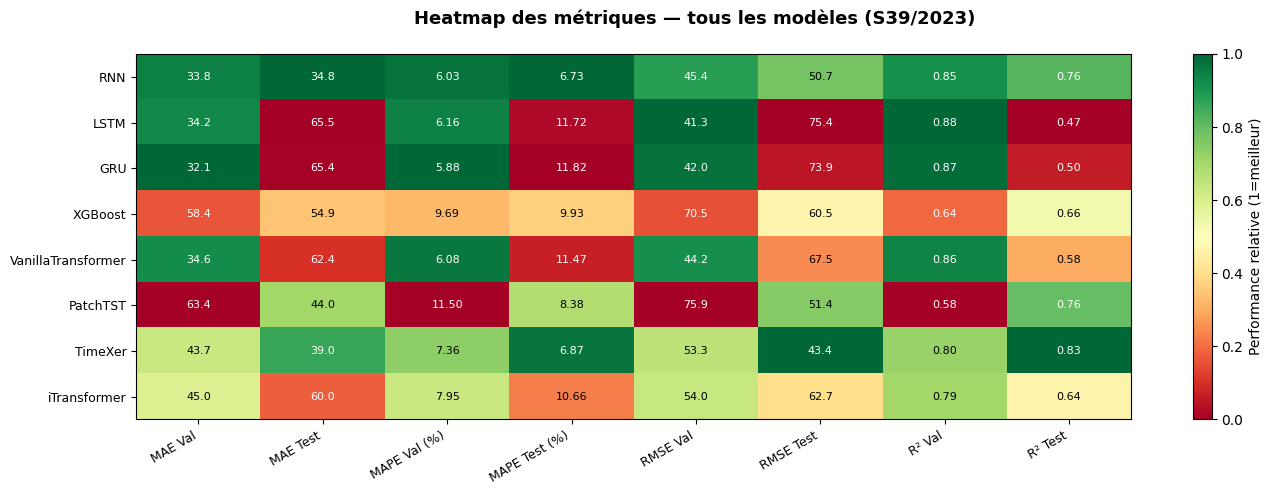

Sauvegardé → img/compare_models_heatmap.png

                      MAE Val   MAE Test  MAPE Val (%)  MAPE Test (%)   RMSE Val  RMSE Test    R² Val   R² Test
Modèle                                                                                                         
RNN                 33.784198  34.784937      6.025200       6.727200  45.401985  50.693119  0.851436  0.762378
LSTM                34.243774  65.497785      6.163967      11.716592  41.339805  75.437428  0.876831  0.473787
GRU                 32.072797  65.351917      5.877947      11.821117  42.024182  73.894610  0.872720  0.495091
XGBoost             58.360333  54.906561      9.691580       9.932406  70.516134  60.481464  0.641623  0.661754
VanillaTransformer  34.570953  62.350547      6.080819      11.473161  44.223770  67.490691  0.859047  0.578812
PatchTST            63.410046  44.014616     11.497301       8.377026  75.904900  51.429792  0.584757  0.755422
TimeXer             43.697189  39.027600      7.358344     

In [5]:
# Construire le DataFrame
rows = []
for r in all_results:
    rows.append({
        'Modèle'       : r['model'],
        'MAE Val'      : r['val']['MAE'],
        'MAE Test'     : r['test']['MAE'],
        'MAPE Val (%)'  : r['val']['MAPE'],
        'MAPE Test (%)' : r['test']['MAPE'],
        'RMSE Val'     : r['val']['RMSE'],
        'RMSE Test'    : r['test']['RMSE'],
        'R² Val'       : r['val']['R2'],
        'R² Test'      : r['test']['R2'],
    })
df_metrics = pd.DataFrame(rows).set_index('Modèle')

# Normalisation colonne par colonne (0=pire, 1=meilleur)
df_norm = df_metrics.copy()
for col in df_norm.columns:
    vmin, vmax = df_norm[col].min(), df_norm[col].max()
    if vmax == vmin:
        df_norm[col] = 0.5
    elif col.startswith('R²'):
        df_norm[col] = (df_norm[col] - vmin) / (vmax - vmin)   # plus haut = meilleur
    else:
        df_norm[col] = 1 - (df_norm[col] - vmin) / (vmax - vmin)  # plus bas = meilleur

fig, ax = plt.subplots(figsize=(14, 5))
fig.suptitle(f'Heatmap des métriques — tous les modèles ({test_label})',
             fontsize=13, fontweight='bold')

cmap = cm.RdYlGn
mat  = df_norm.values
im   = ax.imshow(mat, cmap=cmap, vmin=0, vmax=1, aspect='auto')

ax.set_xticks(range(len(df_metrics.columns)))
ax.set_xticklabels(df_metrics.columns, rotation=30, ha='right', fontsize=9)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=9)

for i in range(len(names)):
    for j, col in enumerate(df_metrics.columns):
        val = df_metrics.iloc[i, j]
        fmt = f'{val:.2f}' if col.startswith('R²') or col.startswith('MAPE') else f'{val:.1f}'
        ax.text(j, i, fmt, ha='center', va='center', fontsize=8,
                color='black' if 0.2 < mat[i, j] < 0.8 else 'white')

plt.colorbar(im, ax=ax, label='Performance relative (1=meilleur)')
plt.tight_layout()
plt.savefig(IMG_PATH.replace('.png', '_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Sauvegardé → img/compare_models_heatmap.png')
print()
print(df_metrics.to_string())

## 4 — Radar chart (Spider plot)

Vue synthétique des performances relatives sur les **métriques Test** normalisées.
Chaque axe est normalisé : **plus le polygone est grand, meilleur est le modèle**.

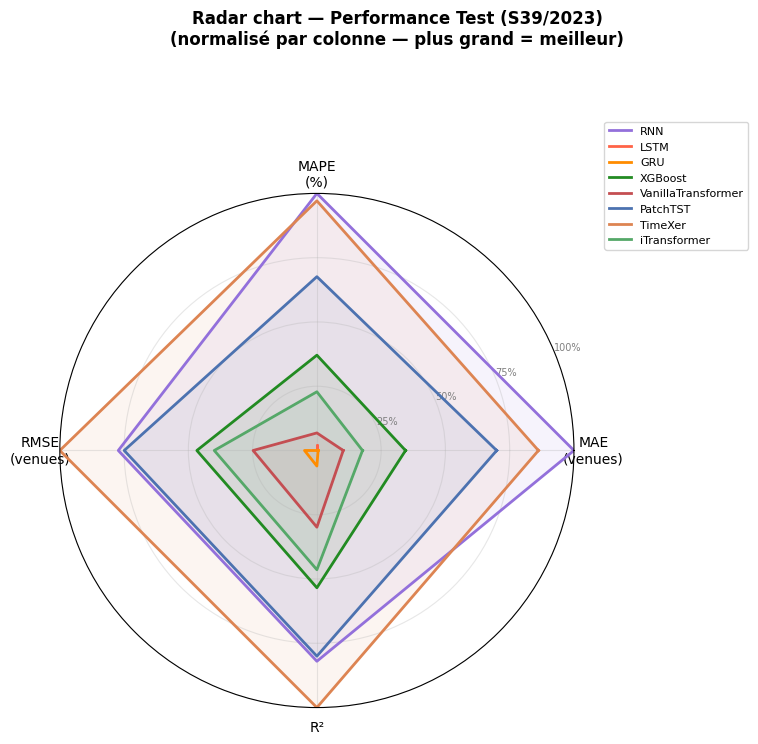

Sauvegardé → img/compare_models_radar.png


In [6]:
# Métriques test uniquement pour le radar
radar_keys   = ['MAE', 'MAPE', 'RMSE', 'R2']
radar_labels = ['MAE\n(venues)', 'MAPE\n(%)', 'RMSE\n(venues)', 'R²']
n_axes       = len(radar_keys)

# Valeurs brutes
raw = np.array([[r['test'][k] for k in radar_keys] for r in all_results])

# Normalisation : tout ramener à [0, 1] où 1 = meilleur
normed = np.zeros_like(raw)
for j, key in enumerate(radar_keys):
    col  = raw[:, j]
    vmin, vmax = col.min(), col.max()
    if vmax == vmin:
        normed[:, j] = 0.5
    elif key == 'R2':
        normed[:, j] = (col - vmin) / (vmax - vmin)
    else:
        normed[:, j] = 1 - (col - vmin) / (vmax - vmin)

# Angles des axes
angles = np.linspace(0, 2 * np.pi, n_axes, endpoint=False).tolist()
angles += angles[:1]   # fermer le polygone

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
fig.suptitle(f'Radar chart — Performance Test ({test_label})\n'
             '(normalisé par colonne — plus grand = meilleur)',
             fontsize=12, fontweight='bold')

for i, r in enumerate(all_results):
    vals = normed[i].tolist()
    vals += vals[:1]
    ax.plot(angles, vals, lw=2,   color=r['color'], label=r['model'])
    ax.fill(angles, vals, alpha=0.08, color=r['color'])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_labels, fontsize=10)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['25%', '50%', '75%', '100%'], fontsize=7, color='grey')
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.15), fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(IMG_PATH.replace('.png', '_radar.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Sauvegardé → img/compare_models_radar.png')